In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
# os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")
from mpl_toolkits.basemap import Basemap

from tqdm import tqdm

In [2]:
import sys 
sys.path.append('..')
from util.kernels import gaussian_kernel
from util.helper_functions import optimize_marginal_likelihood
from models.het_gp import HeteroskedasticGP, predictive_dist_exact
from random_features.gaussian_approximator import GaussianApproximator

../util/hadamard_cuda/__init__.py:28: UserWarning: Including and compiling a custom C++ and CUDA (if available) extension might take a while...
  warnings.warn('Including and compiling a custom C++ and CUDA (if available) extension might take a while...', )
../util/hadamard_cuda/__init__.py:31: UserWarning: CXX variable not set. Setting CXX=g++...
  warnings.warn('CXX variable not set. Setting CXX=g++...',)
../util/hadamard_cuda/__init__.py:36: UserWarning: PATH variable does not include ~/.local/bin. Updating PATH=$HOME/.local/bin:$PATH
  warnings.warn('PATH variable does not include ~/.local/bin. Updating PATH=$HOME/.local/bin:$PATH')


In [3]:
import scipy.io

In [10]:
train = scipy.io.loadmat('../../datasets/export/sarcos/sarcos_inv.mat')['sarcos_inv']
test = scipy.io.loadmat('../../datasets/export/sarcos/sarcos_inv_test.mat')['sarcos_inv_test']

In [36]:
! ls ../../datasets/export/kin40k

kin40k_test_data.asc	kin40k_train_data.asc
kin40k_test_labels.asc	kin40k_train_labels.asc


In [48]:
df = pd.read_csv('../../datasets/export/kin40k/kin40k_train_data.asc', sep='\s+', header=None).values

In [53]:
df = pd.read_csv('../../datasets/export/kin40k/kin40k_train_labels.asc', sep='\s+', header=None).values

In [54]:
df.shape

(10000, 1)

In [33]:
train_data = torch.from_numpy(train[:,:21]).float()
train_labels = torch.from_numpy(train[:, 21][:, np.newaxis]).float()
test_data = torch.from_numpy(test[:,:21]).float()
test_labels = torch.from_numpy(test[:, 21][:, np.newaxis]).float()

In [35]:
train_labels

tensor([[50.2927],
        [44.1042],
        [37.3549],
        ...,
        [22.6997],
        [17.1267],
        [ 6.5245]])

In [4]:
house_prices_df = pd.read_csv(
    'uk_house_prices/pp-monthly-update-new-version.csv',
    header=None
)

In [5]:
columns = [
    'trans_id',
    'price',
    'transfer_date',
    'postcode',
    'property_type',
    'old_new',
    'duration',
    'paon',
    'saon',
    'street',
    'locallity',
    'city',
    'district',
    'county',
    'ppd',
    'rec_status'
]

In [6]:
house_prices_df.columns = columns

In [7]:
post_code_df = pd.read_csv(
    '../../datasets/export/uk_house_prices/ukpostcodes.csv',
    header=None,
    index_col=0
)

/home/jonas/anaconda3/envs/deep_avx/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
post_code_df.columns = ['postcode', 'lat', 'long']

## Columns
- trans_id
- price
- transfer_data
- postcode
- property_type (D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other)
- old_new (Y = a newly built property, N = an established residential building)
- duration (F = Freehold, L= Leasehold)
- paon (Addressable Object Name. Typically the house number or name.)
- saon (Secondary Addressable Object Name. Where a property has been divided into separate units)
- street
- locallity	 
- city	 
- district	 
- county 
- ppd (Indicates the type of Price Paid transaction, A/B)
- rec_status (A = Addition, C = Change, D = Delete)

In [9]:
result = pd.merge(house_prices_df, post_code_df, how="inner", on=['postcode'])

In [44]:
result['price'].max()

56000000

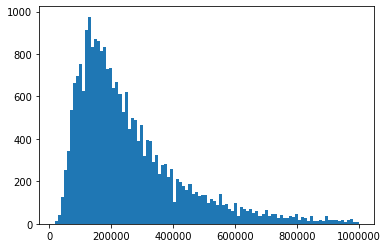

In [47]:
price_data = result['price'].values.reshape(-1)
plt.hist(price_data[price_data < 1000000], bins=100)
plt.show()

In [10]:
result.head()

,trans_id,price,transfer_date,postcode,property_type,old_new,duration,paon,saon,street,locallity,city,district,county,ppd,rec_status,lat,long
0,{D707E535-0122-0AD9-E053-6B04A8C067CC},270000,2002-03-15 00:00,TQ7 4PU,D,N,F,DOLPHIN LODGE,NaN,NaN,KINGSTON,KINGSBRIDGE,SOUTH HAMS,DEVON,A,A,50.314522,-3.915658
1,{D707E535-0121-0AD9-E053-6B04A8C067CC},45000,1998-10-30 00:00,TQ7 4PU,D,N,F,DOLPHIN LODGE,NaN,NaN,KINGSTON,KINGSBRIDGE,SOUTH HAMS,DEVON,A,A,50.314522,-3.915658
2,{D707E535-0E6C-0AD9-E053-6B04A8C067CC},30000,2002-12-03 00:00,SR8 2NA,T,N,F,WEST FARM COTTAGE,NaN,THE VILLAGE,OLD SHOTTON,PETERLEE,COUNTY DURHAM,COUNTY DURHAM,A,A,54.750998,-1.360714
3,{D707E535-0E6D-0AD9-E053-6B04A8C067CC},180000,2021-12-21 00:00,SR8 2NA,T,N,F,WEST FARM COTTAGE,NaN,THE VILLAGE,OLD SHOTTON,PETERLEE,COUNTY DURHAM,COUNTY DURHAM,A,A,54.750998,-1.360714
4,{D707E535-125D-0AD9-E053-6B04A8C067CC},283500,2021-06-25 00:00,SR8 2NA,S,N,F,2,NaN,THE VILLAGE,OLD SHOTTON,PETERLEE,COUNTY DURHAM,COUNTY DURHAM,A,A,54.750998,-1.360714


In [9]:
result['lat'].isnull().sum()

1406

In [10]:
result['long'].isnull().sum()

1406

In [11]:
result['price'].isnull().sum()

0

In [11]:
result = result[~result['lat'].isnull()]
result = result[result['property_type']=='F']

In [13]:
len(result)

24553

In [12]:
data = torch.from_numpy(result[['long', 'lat']].values).float()
labels = torch.from_numpy(result['price'].values).log().unsqueeze(1).float()

In [63]:
labels

tensor([[12.2308],
        [11.6952],
        [11.7357],
        ...,
        [12.2061],
        [11.4186],
        [13.3992]])

In [13]:
N_train = 10000

# shuffle data
permutation = torch.randperm(len(data))
data = data[permutation]
labels = labels[permutation]

train_data = data[:N_train]
train_labels = labels[:N_train]
label_mean = train_labels.mean()
train_labels -= label_mean
test_data = data[N_train:]
test_labels = labels[N_train:]
test_labels -= label_mean

In [60]:
len(test_data)

14553

In [14]:
noise_var = 0.8
log_noise_var = torch.nn.Parameter((torch.ones(1) * noise_var).log(), requires_grad=False)
log_lengthscale = torch.nn.Parameter(torch.cdist(train_data, train_data).median().log(), requires_grad=True)
log_var = torch.nn.Parameter((torch.ones(1) * train_labels.var()), requires_grad=True)

# kernel_fun = lambda x, y: rbf_kernel(x, y, lengthscale=1.)
kernel_fun = lambda x, y: log_var.exp() * gaussian_kernel(x, y, lengthscale=log_lengthscale.exp())
optimize_marginal_likelihood(
    train_data[:5000], train_labels[:5000], kernel_fun, log_lengthscale, log_var, log_noise_var, num_iterations=10, lr=1e-2
)

print('Lengthscale:', log_lengthscale.exp().item())
print('Kernel var:', log_var.exp().item())
print('Noise var:', log_noise_var.exp().item())

# plt.hist((train_data @ train_data.t() / log_lengthscale.data.exp().pow(2)).view(-1))
# plt.show()

### Iteration 0 ###
Loss: 5044.90576171875


../util/LBFGS.py:259: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1627336329221/work/torch/csrc/utils/python_arg_parser.cpp:1005.)
  p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))


Loss: 4980.9990234375
### Iteration 1 ###
Loss: 4980.9990234375
Loss: 4968.3154296875
### Iteration 2 ###
Loss: 4968.3154296875
Loss: 4945.5380859375
### Iteration 3 ###
Loss: 4945.5380859375
Loss: 4935.5166015625
### Iteration 4 ###
Loss: 4935.5166015625
Loss: 4926.78759765625
### Iteration 5 ###
Loss: 4926.78759765625
Loss: 4919.9677734375
### Iteration 6 ###
Loss: 4919.9677734375
Loss: 4915.55029296875
### Iteration 7 ###
Loss: 4915.55029296875
Loss: 4911.32568359375
### Iteration 8 ###
Loss: 4911.32568359375
Loss: 4909.1376953125
### Iteration 9 ###
Loss: 4909.1376953125
Loss: 4907.46337890625
Lengthscale: 0.24113255739212036
Kernel var: 0.2346947193145752
Noise var: 0.800000011920929


In [36]:
a = torch.linspace(-6, 2.0, 100)
b = torch.linspace(50, 55, 100)
grid_data = torch.meshgrid(a, b)

In [37]:
grid_inputs = torch.stack(grid_data, dim=-1).view(-1,2)

In [38]:
kernel_fun = lambda x, y: log_var.exp().item() * gaussian_kernel(x, y, lengthscale=log_lengthscale.exp().item())
f_test_mean_ref, f_test_stds_ref = predictive_dist_exact(
    train_data, grid_inputs, train_labels, log_noise_var.exp().item() * torch.ones_like(train_labels), kernel_fun
)

100%|██████████| 1/1 [00:26<00:00, 26.99s/it]


In [40]:
grid_data[0].numpy()

array([[-6.       , -6.       , -6.       , ..., -6.       , -6.       ,
        -6.       ],
       [-5.919192 , -5.919192 , -5.919192 , ..., -5.919192 , -5.919192 ,
        -5.919192 ],
       [-5.8383837, -5.8383837, -5.8383837, ..., -5.8383837, -5.8383837,
        -5.8383837],
       ...,
       [ 1.8383838,  1.8383838,  1.8383838, ...,  1.8383838,  1.8383838,
         1.8383838],
       [ 1.919192 ,  1.919192 ,  1.919192 , ...,  1.919192 ,  1.919192 ,
         1.919192 ],
       [ 2.       ,  2.       ,  2.       , ...,  2.       ,  2.       ,
         2.       ]], dtype=float32)

In [44]:
f_test_mean_ref.shape

torch.Size([10000, 1])

In [45]:
label_mean

tensor(12.3063)

In [53]:
grid_data[0].numpy().shape

(100, 100)

In [54]:
grid_data[1].numpy().shape

(100, 100)

In [52]:
(f_test_mean_ref.reshape(100,100)+label_mean).numpy().shape

(100, 100)

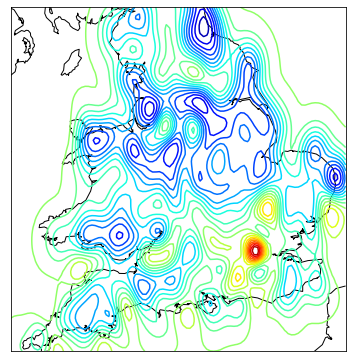

In [39]:
fig = plt.figure(figsize=(5,8))

m = Basemap(projection='merc',
    resolution = 'i',
    llcrnrlon=-6, llcrnrlat=50,
    urcrnrlon=2, urcrnrlat=55
)

# m.scatter(result['long'].values, result['lat'].values, latlon=True,
#           c=np.log(result['price'].values), s=1,
#           cmap='jet', alpha=1)

m.drawcoastlines(linewidth = 1.0, color='black')
m.contour(grid_data[0].numpy(), grid_data[1].numpy(), (f_test_mean_ref.reshape(len(grid_data[0]),len(grid_data[0]))+label_mean).numpy(), cmap='jet', latlon=True, levels=20)

plt.tight_layout()
plt.savefig('../figures/map_gt.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
D = 100

configs = [
    {'method': 'rff', 'proj': 'gaussian', 'degree': 4, 'hierarchical': False, 'complex_weights': False},
    # {'method': 'rff', 'proj': 'gaussian', 'degree': 4, 'bias': 0, 'lengthscale': True, 'hierarchical': False, 'complex_weights': True},
    {'method': 'maclaurin', 'proj': 'srht', 'degree': 10, 'hierarchical': False, 'complex_weights': True},
    # {'method': 'maclaurin', 'proj': 'rademacher', 'degree': 10, 'bias': 0, 'lengthscale': True, 'hierarchical': False, 'complex_weights': True}
]

In [20]:
train_data.mean(dim=0)

tensor([-0.9997, 51.9516])

100%|██████████| 1/1 [00:00<00:00, 54.55it/s]


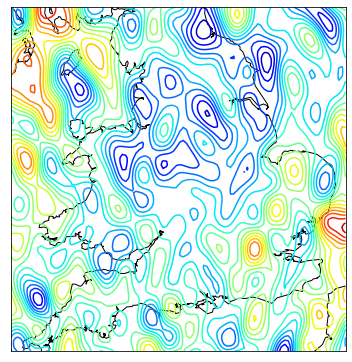

Optimized distribution: [2, 8, 8, 12, 15, 22, 32]
[2, 8, 8, 12, 15, 22, 32]


100%|██████████| 1/1 [00:00<00:00, 26.03it/s]


  2%|▏         | 211/10000 [01:27<1:07:23,  2.42it/s]


KeyboardInterrupt: 

In [26]:
for j, config in enumerate(configs):
    
    feature_encoder = GaussianApproximator(
        2, D,
        approx_degree=10,
        lengthscale=1., var=1.,
        trainable_kernel=False,
        method=config['method'],
        projection_type=config['proj'],
        hierarchical=config['hierarchical'],
        complex_weights=config['complex_weights']
    )

    feature_encoder.log_lengthscale.data = log_lengthscale.data
    feature_encoder.log_var.data = log_var.data

    if config['method'] == 'maclaurin':
        feature_encoder.initialize_sampling_distribution(train_data[:500] - train_data[:500].mean(dim=0))
        # feature_encoder.feature_encoder.measure = Exponential_Measure(True)
        # feature_encoder.feature_encoder.measure.distribution = np.array(D * [1])
        print(feature_encoder.feature_encoder.measure.distribution)

        feature_encoder.resample()

        # solve one GP per test input
        test_means = []
        test_stds = []
        for test_point in tqdm(grid_inputs):
            train_features = feature_encoder.forward(train_data - test_point) #  
            test_features = feature_encoder.forward(torch.zeros_like(test_point).unsqueeze(0)) # 

            het_gp = HeteroskedasticGP(None)

            f_test_mean, f_test_stds = het_gp.predictive_dist(
                train_features, test_features,
                train_labels, log_noise_var.exp().item() * torch.ones_like(train_labels)
            )

            test_means.append(f_test_mean)
            test_stds.append(f_test_stds)

        f_test_mean = torch.hstack(test_means)[0]
        f_test_stds = torch.hstack(test_stds)[0]

    else:
        feature_dist = None
        feature_encoder.resample()
        train_features = feature_encoder.forward(train_data)
        test_features = feature_encoder.forward(grid_inputs)

        het_gp = HeteroskedasticGP(None)

        f_test_mean, f_test_stds = het_gp.predictive_dist(
            train_features, test_features,
            train_labels, noise_var * torch.ones_like(train_labels)
        )
        
    fig = plt.figure(figsize=(5,8))

    m = Basemap(projection='merc',
        resolution = 'i',
        llcrnrlon=-6, llcrnrlat=50,
        urcrnrlon=2, urcrnrlat=55
    )

    # m.scatter(result['long'].values, result['lat'].values, latlon=True,
    #           c=np.log(result['price'].values), s=1,
    #           cmap='jet', alpha=1)

    m.drawcoastlines(linewidth = 1.0, color='black')
    m.contour(grid_data[0].numpy(), grid_data[1].numpy(), (f_test_mean.reshape(len(grid_data[0]),len(grid_data[0]))+label_mean).numpy(), cmap='jet', latlon=True, levels=20)

    plt.tight_layout()
#     plt.savefig('../figures/map_gt.pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [43]:
?? m.colorbar

## Old plot

/home/jonas/anaconda3/envs/deep_avx/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


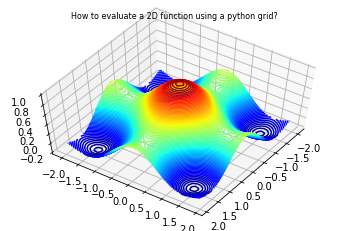

In [3]:
from mpl_toolkits.mplot3d import Axes3D

def f(x, y, freq=1):
    return 0.5 * np.sinc(freq * x) + 0.5 * np.sinc(freq * y)

def f2(x, y, freq=5):
    return 0.5 * np.sin(freq * x) + 0.5 * np.cos(freq * y)


x1_min = -2.0
x1_max = 2.0
x2_min = -2.0
x2_max = 2.0

x1, x2 = np.meshgrid(np.arange(x1_min,x1_max, 0.1), np.arange(x2_min,x2_max, 0.1))

y = f(x1,x2)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.contour3D(x1, x2, y, 100, cmap=pl.cm.jet)

ax.view_init(60, 35)

plt.title("How to evaluate a 2D function using a python grid?" , fontsize=8)

# plt.savefig("evaluate_2d_function_using_meshgrid_05.png", bbox_inches='tight')

plt.show()

In [21]:
np.array([(1./factorial(i)) * 2**i for i in range(5+1)]).sum()

7.266666666666667

In [3]:
import matplotlib.pylab as pylab
params = {
    'legend.fontsize': 'large',
    'figure.figsize': (16, 4), # 2.2*len(csvs)
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'xtick.major.size': 7.0,
    'ytick.major.size': 3.0
}
pylab.rcParams.update(params)

/home/jonas/anaconda3/envs/deep_avx/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


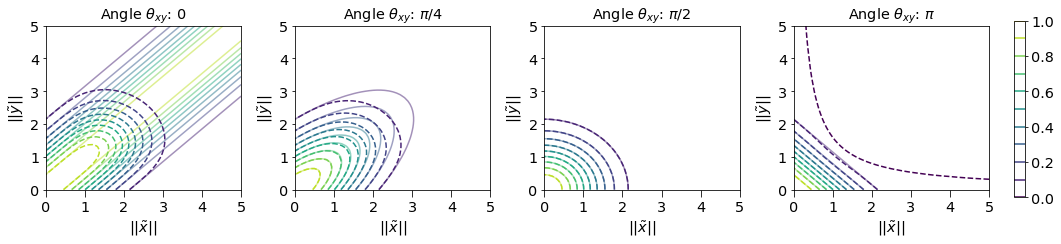

In [33]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import factorial

def f(norm_x, norm_y, cos_term=1., degree=5, freq=1, exact=False):
    pref = np.exp(-(norm_x**2 + norm_y**2) / 2.)
    
    dot = norm_x * norm_y * cos_term
    
    
    macl = np.array([
        (1./factorial(i)) * dot**i for i in range(degree+1)
    ]).sum(axis=0)
#     print(macl.shape)
    if exact:
        macl = np.exp(dot)
    return pref * macl


x1_min = 0
x1_max = 5.1
x2_min = 0
x2_max = 5.1

x1, x2 = np.meshgrid(np.arange(x1_min,x1_max, 0.1), np.arange(x2_min,x2_max, 0.1))

# fig = plt.figure(figsize=(20,10))

cos_term = 1

# ax = fig.add_subplot(121, projection='3d')
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14,3.5))

for i, (ax, angle, label) in enumerate(
    zip(axes, [0, np.pi/4., np.pi/2., np.pi],
        ['0', r'$\pi/4$', r'$\pi/2$', r'$\pi$'])):

    y2 = f(x1, x2, cos_term=np.cos(angle), degree=15, exact=True)
    ax.contour(x1, x2, y2, levels=np.linspace(0,1.0,11), cmap='viridis', alpha=0.5) # 
    
    y1 = f(x1, x2, cos_term=np.cos(angle), degree=3)
    cntr = ax.contour(x1, x2, y1, levels=np.linspace(0,1.0,11), vmin=0, vmax=1.0, cmap='viridis', linestyles='dashed')
    
#     if i == len(axes)-1:
#         fig.colorbar(cntr, ax=ax)

    ax.set_title("Angle $\\theta_{{xy}}$: {}".format(label))
    ax.set_xlabel(r'$\|\| \tilde{x} \|\|$')
    ax.set_ylabel(r'$\|\| \tilde{y} \|\|$')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_yticks([0,1,2,3,4,5])

#fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1.01, 0.2, 0.01, 0.7])
fig.colorbar(cntr, cax=cbar_ax)
# ax.cax.colorbar(cntr)
# ax.cax.toggle_label(True)

    
plt.tight_layout()
plt.savefig('../figures/ml_bias.pdf', dpi=300, bbox_extra_artists=(cbar_ax,), bbox_inches='tight')

plt.show()

In [19]:
print(y1)

[[ 1.00000000e+00  9.95012479e-01  9.80198673e-01 ...  1.59667839e-05
   9.92950431e-06  6.11356797e-06]
 [ 9.95012479e-01  9.80198673e-01  9.55997482e-01 ...  9.92928154e-06
   6.11341099e-06  3.72654394e-06]
 [ 9.80198673e-01  9.55997482e-01  9.23116346e-01 ...  6.10037195e-06
   3.71736587e-06  2.24260144e-06]
 ...
 [ 1.59667839e-05  9.92928154e-06  6.10037195e-06 ... -9.04645167e-06
  -6.27605718e-06 -4.30073008e-06]
 [ 9.92950431e-06  6.11341099e-06  3.71736587e-06 ... -6.27605718e-06
  -4.35375086e-06 -2.98323891e-06]
 [ 6.11356797e-06  3.72654394e-06  2.24260144e-06 ... -4.30073008e-06
  -2.98323891e-06 -2.04400869e-06]]


In [18]:
print(np.abs(y1-y2))

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.33226763e-15 8.64863736e-14 ... 2.22770219e-10
  1.56977541e-10 1.09230611e-10]
 [0.00000000e+00 8.64863736e-14 5.43476375e-12 ... 1.31960117e-08
  9.28730035e-09 6.45452678e-09]
 ...
 [0.00000000e+00 2.22770219e-10 1.31960117e-08 ... 9.04645167e-06
  6.27605718e-06 4.30073008e-06]
 [0.00000000e+00 1.56977541e-10 9.28730035e-09 ... 6.27605718e-06
  4.35375086e-06 2.98323891e-06]
 [0.00000000e+00 1.09230611e-10 6.45452678e-09 ... 4.30073008e-06
  2.98323891e-06 2.04400869e-06]]


In [ ]:
# vectors with large norms will ALWAYS make the kernel go to 0!!!

In [13]:
np.cos(np.pi)

-1.0

In [23]:
x1

array([[-2. , -1.9, -1.8, ...,  1.7,  1.8,  1.9],
       [-2. , -1.9, -1.8, ...,  1.7,  1.8,  1.9],
       [-2. , -1.9, -1.8, ...,  1.7,  1.8,  1.9],
       ...,
       [-2. , -1.9, -1.8, ...,  1.7,  1.8,  1.9],
       [-2. , -1.9, -1.8, ...,  1.7,  1.8,  1.9],
       [-2. , -1.9, -1.8, ...,  1.7,  1.8,  1.9]])

In [24]:
x2

array([[-2. , -2. , -2. , ..., -2. , -2. , -2. ],
       [-1.9, -1.9, -1.9, ..., -1.9, -1.9, -1.9],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       ...,
       [ 1.7,  1.7,  1.7, ...,  1.7,  1.7,  1.7],
       [ 1.8,  1.8,  1.8, ...,  1.8,  1.8,  1.8],
       [ 1.9,  1.9,  1.9, ...,  1.9,  1.9,  1.9]])